# Privacy-Enhancing Technologies in an Attribution Measurement Workflow 

This notebook contains three digital advertising campaign attribution measurement workflow variants that illustrate how three different privacy-enahncing technologies (PETS) can enhance the privacy-preserving properties of the workflow. The format of the sample input data is informed by the schemas defined in the [**Attribution Data Matching Protocol (ADMaP) specification**](https://iabtechlab.com/admap/) and **Universal CAPI v1**.

## Dependencies

The examples in this notebook rely on several Python packages. These are enumerated in the `requirements.txt` file found in the same directory and can be installed using [pip](https://pip.pypa.io/en/stable/) via a command such as the below:
```
python -m pip install -r requirements.txt
```

## Example ADMaP-Compatible Data

A few common dependencies are leveraged to generate example data.

In [1]:
import random
from tqdm.notebook import tqdm
import faker

A common space of email addresses (which are used as keys for matching event data with conversion data throughout this document) is generated below and leveraged for creating the simulated records within example data sets.

In [2]:
random.seed(123)
faker.Faker.seed(123)
fake = faker.Faker()
emails = [fake.email() for _ in tqdm(range(10000))]

  0%|          | 0/10000 [00:00<?, ?it/s]

The function below is used to encapsulate and/or display data as a table in a legible manner.

In [3]:
import pandas as pd

def table(data, columns):
    df = pd.DataFrame(data, columns=columns)
    return df

### Publisher Engagement Events

The code block below generates simulated engagement event data that might be supplied by a publisher to a clean room.

In [4]:
emails = random.sample(emails, 10000)
campaigns = ['Red', 'Orange', 'Yellow', 'Green', 'Blue', 'Purple']
regions = ['NA', 'LATAM', 'EMEA', 'APAC', 'ROW']

events = [
    [
        random.randint(1, 1),        # Space ID
        emails[i],                   # user_data.email_address
        'click',                     # event_type
        random.choice(campaigns),    # event_properties.promotion_name
        random.choice(regions),      # user_data.address.region
        random.choice([False, True]) # user_data.opt_out
    ]
    for i in tqdm(range(5000))
]

table(
    events,
    [
        "Space ID",
        "user_data.email_address",
        "event_type",
        "event_properties.promotion_name",
        "user_data.address.region",
        "user_data.opt_out"
    ]
)

  0%|          | 0/5000 [00:00<?, ?it/s]

,Space ID,user_data.email_address,event_type,event_properties.promotion_name,user_data.address.region,user_data.opt_out
0,1,ugates@example.com,click,Purple,LATAM,True
1,1,varnold@example.net,click,Purple,ROW,False
2,1,moorewayne@example.com,click,Yellow,LATAM,True
3,1,jamesrogers@example.net,click,Blue,ROW,False
4,1,cranekenneth@example.org,click,Blue,ROW,True
...,...,...,...,...,...,...
4995,1,cgray@example.org,click,Purple,LATAM,True
4996,1,richard35@example.net,click,Orange,ROW,False
4997,1,ryanheath@example.org,click,Green,ROW,True
4998,1,pottstroy@example.net,click,Yellow,ROW,True


### Advertiser Conversions

The code block below generates simulated conversion data that might be supplied by an advertiser to a clean room.

In [5]:
emails = random.sample(emails, 1000)
types = ['Purchase', 'Subscription']

conversions = [
    [
        random.randint(1, 1),  # Space ID
        emails[i],             # user_data.email_address
        random.choice(types)   # event_type
    ]
    for i in range(len(emails))
]

table(conversions, ["Space ID", "user_data.email_address", "event_type"])

,Space ID,user_data.email_address,event_type
0,1,connorpacheco@example.com,Subscription
1,1,chadtrevino@example.net,Subscription
2,1,rodriguezrobert@example.org,Purchase
3,1,tonya48@example.com,Purchase
4,1,pfitzgerald@example.org,Subscription
...,...,...,...
995,1,rodriguezjonathan@example.net,Subscription
996,1,klowery@example.org,Subscription
997,1,cunninghamtimothy@example.com,Subscription
998,1,twhite@example.org,Subscription


## Privacy-Preserving Aggregation of Conversions with $k$-anonymity

This section illustrates how $k$-anonymity can be incorporated into a basic aggregation workflow. The examples in this section make use of the [ANJANA](https://anjana.readthedocs.io/en/latest/) library. While this library is sufficient for the examples in this document and is chosen for its portability and compatibility with Python, alternative libraries are recommended for production use cases. One example of such is the [ARX](https://github.com/arx-deidentifier/arx) library.

### Reference Workflow

The workflow below (in its plaintext reference version) joins the publisher engagement events with the advertiser conversions and aggregates the number of conversions for each distinct campaign in the overlap.

In [6]:
join_ka_ref = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        region_e,
        opt_e,
        type_c
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, opt_e) in events
    for (spaceid_c, key_c, type_c) in conversions
    if key_e == key_c
]

aggregate_ka_ref = [
    [
        campaign,
        sum([
            1
            for (_, _, campaign_, _, _, _) in join_ka_ref
            if campaign == campaign_
        ])
    ]
    for campaign in campaigns # Unique campaigns.
]

table(aggregate_ka_ref, ["event_properties.promotion_name", "count(Purchase|Subscription)"])

,event_properties.promotion_name,count(Purchase|Subscription)
0,Red,80
1,Orange,88
2,Yellow,100
3,Green,74
4,Blue,96
5,Purple,85


### Workflow Incorporating $k$-anonymity

The workflow below incorporates $k$-anonymity into the result of the join operation.

In [7]:
import numpy as np
import pandas as pd
import anjana.anonymity

# Add an age and sex column to the data in order to make the example more interesting.
data = table([
    row[2:] + [
        random.randint(18, 88),
        random.choice(['F', 'M'])
    ]
    for row in join_ka_ref
], [
    'event_properties.promotion_name',
    'user_data.address.region',
    'user_data.opt_out',
    'event_type',
    'user_data.age',
    'user_data.sex'
])

# The below function converts an age value into the 10-year range
# into which it falls.
def range_from(age):
    for i in range(0, 100, 10):
        if i <= int(age) < i + 10:
            return '[' + str(i) + ', ' + str(i + 10) + ')'

# Define the quasi-identifier hierarchies.
hierarchies = {
    'user_data.age': {
        0: data['user_data.age'].values,
        1: [range_from(v) for v in data['user_data.age'].values]
    },
    'user_data.sex': {
        0: data['user_data.sex'].values,
        1: np.array(["*"] * len(data["user_data.sex"].values)) # Suppression.
    },
    'user_data.address.region': {
        0: data['user_data.address.region'].values,
        1: np.array(['*'] * len(data['user_data.sex'].values)) # Suppression.
    }
}

# The function below computes the transformed data set for
# a specified parameter set and collection of hierarchies.
def workflow(k, l_div, t, supp_level, hierarchies, data):
    return anjana.anonymity.k_anonymity(
        data,
        [ # Identifiers.
            'event_properties.promotion_name'
        ],
        [ # Quasi-identifiers.
            'user_data.age',
            'user_data.sex',
            'user_data.address.region'
        ],
        k,
        supp_level,
        hierarchies
    )

workflow(10, 2, 0.5, 50, hierarchies, data)

,index,event_properties.promotion_name,user_data.address.region,user_data.opt_out,event_type,user_data.age,user_data.sex
0,0,*,*,True,Subscription,"[30, 40)",F
1,1,*,*,False,Purchase,"[40, 50)",F
2,2,*,*,True,Purchase,"[50, 60)",M
3,3,*,*,False,Subscription,"[30, 40)",F
4,4,*,*,False,Subscription,"[80, 90)",F
...,...,...,...,...,...,...,...
511,518,*,*,True,Purchase,"[20, 30)",F
512,519,*,*,True,Purchase,"[80, 90)",F
513,520,*,*,False,Subscription,"[60, 70)",F
514,521,*,*,True,Purchase,"[40, 50)",M


### Effect of Parameter on Results

Interact with the slider below to observe the effect of different $k$ values.

In [8]:
import ipywidgets
from IPython.display import display, clear_output

output_ka = ipywidgets.Output()
slider_ka = ipywidgets.IntSlider(
    value=10,
    min=1,
    max=10,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    layout=ipywidgets.Layout(width='300px'),
    readout=True,
    readout_format='d'
)

def on_change_slider_ka(change):
    global cache
    k = change['new']
    with output_ka:
        clear_output(wait=True)
        display(workflow(k, 2, 0.5, 50, hierarchies, data))

slider_ka.observe(on_change_slider_ka, names='value')
display(
    ipywidgets.HBox([
        ipywidgets.Label(
            'k:',
            layout=ipywidgets.Layout(width='130px')
        ),
        slider_ka
    ]),
    output_ka
)
on_change_slider_ka({'new': 10}) # Display initial output.

Output()

## Privacy-Preserving Aggregation of Conversions with Differential Privacy (DP)

This section presents and discusses a differentially private aggregation workflow for conversion data. The examples in this section make use of the [OpenDP](https://docs.opendp.org/en/stable/index.html) library. OpenDP was chosen for its portability; alternatives include the [collection of DP libraries and tools made available by Google](https://github.com/google/differential-privacy).

### Reference Workflow

The workflow below (in its plaintext reference version) joins the publisher engagement events with the advertiser conversions and aggregates the number of conversions for each distinct campaign in the overlap. Usually, the event and conversion data would be sent by the publisher and advertiser (respectively) to a clean room. The clean room would then run this workflow. See the [ADMaP standard](https://iabtechlab.com/admap/) for a more detailed discussion and examples.

In [9]:
join_dp_ref = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        region_e,
        opt_e,
        type_c
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, opt_e) in events
    for (spaceid_c, key_c, type_c) in conversions
    if key_e == key_c
]

aggregate_dp_ref = [
    [
        campaign,
        sum([
            1
            for (_, _, campaign_, _, _, _,) in join_dp_ref
            if campaign == campaign_
        ])
    ]
    for campaign in campaigns # Unique campaigns.
]

table(aggregate_dp_ref, ["event_properties.promotion_name", "count(Purchase|Subscription)"])

,event_properties.promotion_name,count(Purchase|Subscription)
0,Red,80
1,Orange,88
2,Yellow,100
3,Green,74
4,Blue,96
5,Purple,85


### Workflow Variant with Differentially Private Output

The workflow below computes a differentially private total for each campaign. It is encapsulated in a function so that it can be reused in the interactive examples in subsequent sections.

In [10]:
import polars as pl
import opendp.prelude as dp

dp.enable_features("contrib")

def build_comparison(epsilon=1.0, split_evenly_over=5):
    # Table for comparing DP and non-DP results.
    comparison = []

    # Build a differentially private count of conversions for each campaign.
    for campaign in tqdm(campaigns):
        # Extract all the raw rows for this particular campaign.
        filtered = [
            1
            for [spaceid_e, type_e, campaign_e, region_e, opt_e, type_c] in join_dp_ref
            if campaign_e == campaign
        ]
        df_filtered = pl.LazyFrame(filtered, orient="row")
    
        # Build context for query.
        context = dp.Context.compositor(
            data=df_filtered,
            privacy_unit=dp.unit_of(contributions=5),
            privacy_loss=dp.loss_of(epsilon=epsilon),
            split_evenly_over=split_evenly_over,
        )
    
        # Perform differentially private query.
        count_conversions = context.query().select(dp.len())
    
        # Add raw count and differentially private count.
        comparison.append([
            campaign,
            len(filtered),
            count_conversions.release().collect()['len'][0]
        ])

    # Create the final table with a row for the totals.
    df_comparison = table(comparison, ['campaign', 'non-DP', 'DP'])
    df_comparison.loc['Total'] = df_comparison.sum(numeric_only=True)
    df_comparison.loc['Total', 'campaign'] = ''
    return df_comparison

df_comparison = build_comparison()
df_comparison

  0%|          | 0/6 [00:00<?, ?it/s]

,campaign,non-DP,DP
0,Red,80.0,99.0
1,Orange,88.0,55.0
2,Yellow,100.0,41.0
3,Green,74.0,78.0
4,Blue,96.0,40.0
5,Purple,85.0,58.0
Total,,523.0,371.0


The differentially private results are an example of *output privacy*: the final aggregate values are not exactly the true values and limit the amount of information that can be inferred about the inputs. However, *input privacy* is not achieved because the entity computing the differentially private results (such as a clean room) must use the raw data to calculate the differentially private results.

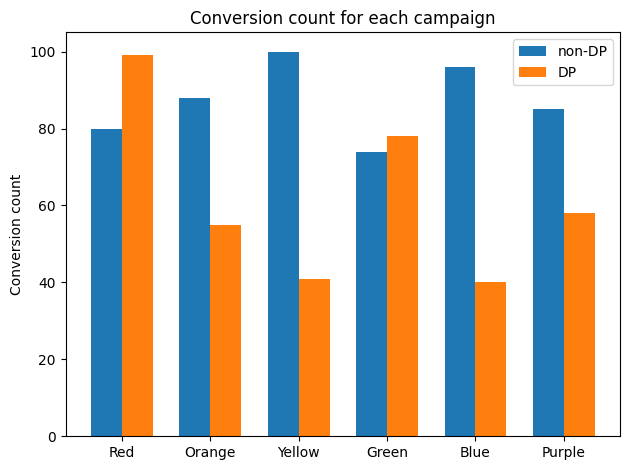

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(df):
    x = np.arange(len(campaigns))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, df['non-DP'].tolist()[:-1], width, label='non-DP')
    rects2 = ax.bar(x + width/2, df['DP'].tolist()[:-1], width, label='DP')
    ax.set_ylabel('Conversion count')
    ax.set_title('Conversion count for each campaign')
    ax.set_xticks(x)
    ax.set_xticklabels(campaigns)
    ax.legend()
    fig.tight_layout()
    plt.show()

plot_comparison(df_comparison)

### Effect of Privacy Loss Parameter on Results

Interact with the slider below to observe the effect of different epsilon values.

In [12]:
import ipywidgets
from IPython.display import display, clear_output

cache = {} # Cache for storing previous calculations.

output_dp = ipywidgets.Output()
slider_dp = ipywidgets.FloatSlider(
    value=1.0,
    min=0.2,
    max=5,
    step=0.1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    layout=ipywidgets.Layout(width='600px'),
    readout=True,
    readout_format='.1f'
)

def on_change_slider_dp(change):
    global cache
    epsilon = change['new']
    with output_dp:
        if epsilon in cache:
            df_comparison = cache[epsilon]
        else:
            df_comparison = build_comparison(change['new'], 10)
            cache[epsilon] = df_comparison
        clear_output(wait=True)
        plot_comparison(df_comparison)

slider_dp.observe(on_change_slider_dp, names='value')
display(
    ipywidgets.HBox([
        ipywidgets.Label(
            'Epsilon (Privacy Loss):',
            layout=ipywidgets.Layout(width='130px')
        ),
        slider_dp
    ]),
    output_dp
)
on_change_slider_dp({'new': 1.0}) # Display initial output.

Output()

### Privacy Budget and Limits on Number of Queries

When executing differentially private queries, each query depletes the privacy budget. A data set cannot be queried once the privacy budget is depleted (doing so would compromise the privacy guarantees associated with the chosen parameters). This is illustrated in the example below: the fourth query causes the OpenDP library to raise an exception.

In [13]:
filtered = [
    1
    for [spaceid_e, type_e, campaign_e, region_e, opt_e, type_c] in join_dp_ref
    if campaign_e == "Orange"
]
df = pl.LazyFrame(filtered, orient="row")

context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=5),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=3,
)

# Up to three queries are permitted.
context.query().select(dp.len()).release().collect()['len'][0]
context.query().select(dp.len()).release().collect()['len'][0]
context.query().select(dp.len()).release().collect()['len'][0]

# The fourth query raises an exception.
try:
    context.query().select(dp.len()).release().collect()['len'][0]
except Exception as e:
    print(e)

Privacy allowance has been exhausted


## Privacy-Preserving Aggregation of Encrypted Conversion Data with Homomorphic Encryption

This section presents and discusses an aggregation workflow for conversion data in which the conversion type within each record remains encrypted during computation. The examples in this section make use of the [pailliers](https://pailliers.readthedocs.io) library that implements the [Paillier cryptosystem](https://en.wikipedia.org/wiki/Paillier_cryptosystem) (a form of homomorphic encryption). While this library is sufficient for the examples in this document and is chosen for its portability and compatibility with Python, alternative libraries that implement fully homomorphic encryption schemes are recommended. One example of such is the [OpenFHE library](https://openfhe.org/).

### Reference Workflow

The workflow below (in its plaintext reference version) joins the publisher engagement events with the advertiser conversions and aggregates the number of conversions of a specific type (in this case, purchases) for each distinct campaign in the overlap.

In [14]:
join_he_ref = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        type_c
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, opt_e) in events
    for (spaceid_c, key_c, type_c) in conversions
    if key_e == key_c
]

aggregate_he_ref = [
    [
        campaign,
        sum([
            1
            for (_, _, campaign_, event_type) in join_he_ref
            if campaign == campaign_ and event_type == 'Purchase'
        ])
    ]
    for campaign in campaigns # Unique campaigns.
]

table(aggregate_he_ref, ["event_properties.promotion_name", "count(Purchase)"])

,event_properties.promotion_name,count(Purchase)
0,Red,38
1,Orange,45
2,Yellow,53
3,Green,30
4,Blue,47
5,Purple,38


### Workflow Variant with Encrypted Event Type Values

The transformation below encrypts the event column in the original conversion data. This is accomplished by splitting it into two columns (one for each possible event name), encoding the type of event by setting the appropriate column value to ``1`` (and the other column to ``0``), and then encrypting both columns

In [15]:
import pailliers

secret_key = pailliers.secret(128)        # Owned by the recipient (such as the advertiser).
public_key = pailliers.public(secret_key) # Shared with all parties (such as the publisher and data clean room).

conversions_enc = [
    [
        spaceid_c,
        key_c,
        pailliers.encrypt(public_key, 1 if event_type == 'Purchase' else 0),
        pailliers.encrypt(public_key, 1 if event_type == 'Subscription' else 0)
    ]
    for (spaceid_c, key_c, event_type) in tqdm(conversions)
]

table(conversions_enc, ["Space ID", "user_data.email_address", "event_type = Purchase", "event_type = Subcription"])

  0%|          | 0/1000 [00:00<?, ?it/s]

,Space ID,user_data.email_address,event_type = Purchase,event_type = Subcription
0,1,connorpacheco@example.com,2349267876533479745526986878985223183196094021...,2145737786664919860987560000473242124379524734...
1,1,chadtrevino@example.net,1248471899763423461611827189222621362891706447...,1962552778486876502861247806076888679298726214...
2,1,rodriguezrobert@example.org,2238371425532390539206468575167768644529333347...,2716303363870288557236931318158310921174587977...
3,1,tonya48@example.com,1964199298338688390692502844717540544085015869...,2170486631802212987135822416405133248409164295...
4,1,pfitzgerald@example.org,1156015446441506848517968556048361747915576411...,2499642145448738913520176680757268520436211401...
...,...,...,...,...
995,1,rodriguezjonathan@example.net,2800936424133529223854817389042595888754608401...,1641381482104463909705621116281448922160915689...
996,1,klowery@example.org,1924532061977732955778183656904508477173724074...,1787007168098252288839273385542716982581924618...
997,1,cunninghamtimothy@example.com,2697839087014448262178738536288290692156863733...,1742986708995689210643487125831091782649474157...
998,1,twhite@example.org,8638719416495017622942498265667968773270717989...,1723354710544895630472676283442910557356108758...


The workflow below preserves the input-output behavior of the plaintext workflow, but maintains some of the field values in encrypted form by relying on homomorphic encryption. This achieves *input privacy*: if the entity performing the aggregation (such as a data clean room) does not have access to the secret key, it cannot decrypt the information about each individual row.

In [16]:
join_he = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        count_p,
        count_s
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, age_e) in events
    for (spaceid_c, key_c, count_p, count_s) in conversions_enc
    if key_e == key_c
]

aggregate_he_enc = [
    [
        campaign,
        sum([ # Summation of ciphertexts via Python operator overloading.
            count_p
            for (_, _, campaign_, count_p, _) in join_he
            if campaign == campaign_
        ])
    ]
    for campaign in campaigns # Unique campaigns.
]

Below is the encrypted version of the aggregate results. The number of purchases for each campaign is still in its ciphertext form. From the perspective of the aggregating entity, *output privacy* is achieved. However, these could be forwarded to another recipient that does possess the secret key (such as the advertiser).

In [17]:
table(aggregate_he_enc, ["event_properties.promotion_name", "count(Purchase)"])

,event_properties.promotion_name,count(Purchase)
0,Red,3322060321865166367795006596246482999627303705...
1,Orange,2920452760143398548272063612933737358586222199...
2,Yellow,2605978143418263115516687892658567739074054959...
3,Green,2652768843090637965223570269284503176194132577...
4,Blue,2277919199327545306010762582590126194120256946...
5,Purple,1836055072565470691102871897845057404722831882...


The decrypted results can be viewed by using the secret key. In this case, the outputs are exact and the owner of the secret key is free to deduce any information they can from these counts.

In [18]:
aggregate_he_dec = [
    [
        campaign,
        pailliers.decrypt(secret_key, count)
    ]
    for (campaign, count) in aggregate_he_enc
]
table(aggregate_he_dec, ["event_properties.promotion_name", "count(Purchase)"])

,event_properties.promotion_name,count(Purchase)
0,Red,38
1,Orange,45
2,Yellow,53
3,Green,30
4,Blue,47
5,Purple,38


In this case, *output privacy* may not be achieved. For example, it is possible that only a single purchase occurred during the campaign (which may allow an advertiser to deduce the identity of the user whose data contributed to the aggregate result).